# Router V0.0
Energy efficienty based router!

In [1]:
import osmnx as ox
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randrange
import copy

import re

import urllib.request
import json
import certifi

In [2]:
from IPython.core.display import display, HTML, Markdown
import imageio

## Utils
Classes for interacting with the road network

In [57]:
def get_elevations(lat_list, lon_list):

    d_ar=[{}]*len(lat_list)
    for i in range(len(lat_list)):
        d_ar[i]={"latitude":lat_list[i],"longitude":lon_list[i]}
    location={"locations":d_ar}
    json_data=json.dumps(location,skipkeys=int).encode('utf8')

    #SEND REQUEST 
    url="https://api.open-elevation.com/api/v1/lookup"
    response = urllib.request.Request(url,json_data,headers={'Content-Type': 'application/json'})
    fp=urllib.request.urlopen(response, cafile = certifi.where())

    #RESPONSE PROCESSING
    res_byte=fp.read()
    res_str=res_byte.decode("utf8")
    js_str=json.loads(res_str)
    #print (js_mystr)
    fp.close()

    #GETTING ELEVATION 
    response_len=len(js_str['results'])
    elev_list=[]
    for j in range(response_len):
        elev_list.append(js_str['results'][j]['elevation'])

    return elev_list

class RoadNetwork:
    def __init__(self):
        self.graph = None
        
        self.nodes = None
        self.edges = None
        
        self.node_elevations = {}
    
    # ===================== LOADING AND PREPROCESSING
    # Load a graph from a file
    def load_from_file(self, filename):
        self.graph = ox.graph_from_xml(filename, bidirectional = False, simplify = True, retain_all=False)
    
    # Remove non highway edges
    def remove_non_highway(self):
        edges_to_remove = []
        G = self.graph

        # Find edges that are not highways (roads)
        for n in G.edges:
            # print(n)
            data = G.edges[n]
            if('highway' not in data):
                # print("Not a highway")
                edges_to_remove.append(n)
                pass
            elif('area' in data):
                edges_to_remove.append(n)
            elif(data['highway'] == 'footway' 
                 or data['highway'] == 'service'
                 or data['highway'] == 'path'):
                edges_to_remove.append(n)

        # Remove them
        for edge_id in edges_to_remove:
            G.remove_edge(edge_id[0], edge_id[1])

        # Trim nodes with no connection
        remove = [node for node,degree in dict(G.degree()).items() if degree == 0]
        G.remove_nodes_from(remove)
    
    # Converts graph into geo-dataframe
    def graph_to_gdfs(self):
        self.nodes, self.edges = ox.graph_to_gdfs(self.graph)
        
    def generate_elevations(self):
        G = self.graph
        
        lat_list = []
        lon_list = []
        
        max_per_request = 0
        
        for n in G.nodes:
            data = G.nodes[n]
            lat_list.append(data["y"])
            lon_list.append(data["x"])
            # print(self.graph.nodes[n])
        # print(lat_list)
        
        elevation_list = get_elevations(lat_list, lon_list)
        # print(elevation_list)
        
        
        i = 0
        for n in G.nodes:
            self.graph.nodes[n]["elevation"] = elevation_list[i]
            # print(i)
            i += 1
    
    # Pre-processes the network to make it easier to navigate on
    def preprocess(self):
        self.remove_non_highway()
        self.generate_elevations()
        self.graph_to_gdfs()
        
    # ===================== GRAPH OPERATIONS
    # TODO: OPTIMIZE THESE!!!
    
    # TODO: Make good subgraph interface, restrict search space
    
    # Returns list of node ids contained within graph
    def get_node_ids(self):
        return self.nodes.index
    
    # Gets node data from openstreetmap id
    def get_node(self, osmid):
        node = self.nodes[self.nodes.index == osmid].iloc[0]
        return node
    
    def get_edge_ids(self):
        return self.edges.index
    
    def get_edge(self, edge_id):
        return network.edges.loc[edge_id]
    
    def get_edge_df(self, edge_id):
        return network.edges.loc[edge_id[0], edge_id[1], :]
    
    def get_connected_edges_from_node(self, node):
        return network.edges.loc[node.name, :, :]
    
    # ===================== PLOTTING
    # Basic node edge plot
    def plot_basic(self, figsize = (8, 8)):
        fig, ax = plt.subplots(figsize = figsize)
        
        fig.set_facecolor((0.95, 0.95, 0.95))
        
        # Plot nodes and edges
        self.nodes.plot(ax = ax, color = "black", alpha = 0.3, markersize = 1)
        self.edges.plot(ax = ax, color = "black", alpha = 0.1)
        
        ax.axis('off')
        
        # return the axis incase we want to plot more ontop
        return fig, ax
    
    # Plots a point
    def plot_point(self, ax):
        pass
    
    # Plots a node
    def plot_node(self, ax, node, color = "orange"):
        x, y = node['x'], node['y']
        
        ax.scatter([x], [y], color = color, zorder = 10)
        
    # Plots a node from its id
    def plot_node_from_id(self, ax, osmid, color = "orange"):
        node =  self.get_node(osmid)
        self.plot_node(ax, node, color)
    
    def _repr_html_(self):
        self.plot_basic((5,5))
        return ""

## Network loading and inspection

C:\Users\thoma\AppData\Local\Temp/ipykernel_40464/3298730036.py:12: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  fp=urllib.request.urlopen(response, cafile = certifi.where())


plotting..


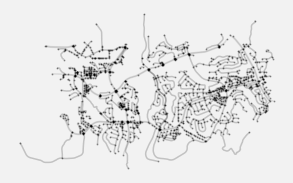

In [89]:
network = RoadNetwork()
network.load_from_file('maps/sanmarco.osm')
network.preprocess()
print("plotting..")
network

### Plotting a single, random node

#### [Node ID: 49612145](https://www.openstreetmap.org/node/49612145)

y                                33.103134
x                              -117.284027
elevation                               78
highway                                NaN
geometry     POINT (-117.284027 33.103134)
Name: 49612145, dtype: object


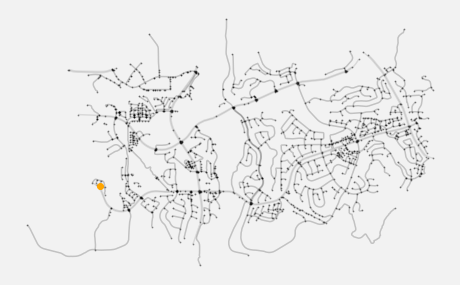

In [96]:
# Get all ids and pick a random one
node_ids = network.get_node_ids()
test_id = node_ids[randrange(0, len(node_ids))]
test_id = node_ids[52]

# Display id with a link to the osm page
display(Markdown("#### " + "[Node ID: %s](https://www.openstreetmap.org/node/%s)" % (test_id, test_id)))

# Get the node data
node = network.get_node(test_id)
print(node)

# Plot the node
fig, ax = network.plot_basic()
network.plot_node(ax, node)

### Plotting a single, random edge

#### [Edge ID: (49074631, 49074630, 0)](https://www.openstreetmap.org/way/5958469)

#### [Node 1 ID: 49074631](https://www.openstreetmap.org/node/49074631)

#### [Node 2 ID: 49074630](https://www.openstreetmap.org/node/49074630)

osmid                                                 5958469
name                                             Quinton Road
highway                                           residential
oneway                                                  False
length                                                 91.655
geometry    LINESTRING (-117.1122828 32.9646258, -117.1122...
maxspeed                                                  NaN
lanes                                                     NaN
access                                                    NaN
bridge                                                    NaN
ref                                                       NaN
service                                                   NaN
landuse                                                   NaN
width                                                     NaN
Name: (49074631, 49074630, 0), dtype: object


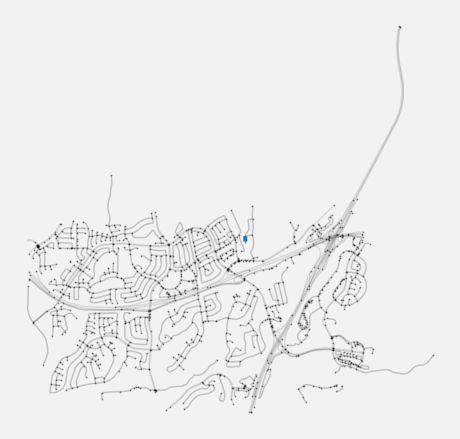

In [68]:
# Get all edge ids and pick a random one
edge_ids = network.get_edge_ids()
test_id = edge_ids[randrange(0, len(edge_ids))]

edge = network.get_edge(test_id)

display(Markdown("#### " + "[Edge ID: %s](https://www.openstreetmap.org/way/%s)" % (test_id, edge['osmid'])))

display(Markdown("#### " + "[Node 1 ID: %s](https://www.openstreetmap.org/node/%s)" % (test_id[0], test_id[0])))
display(Markdown("#### " + "[Node 2 ID: %s](https://www.openstreetmap.org/node/%s)" % (test_id[1], test_id[1])))


print(edge)

edge_df = network.get_edge_df(test_id)
# Plot the edge
fig, ax = network.plot_basic()
edge_df.plot(ax = ax, linewidth = 4)
display()

### Getting connected ways

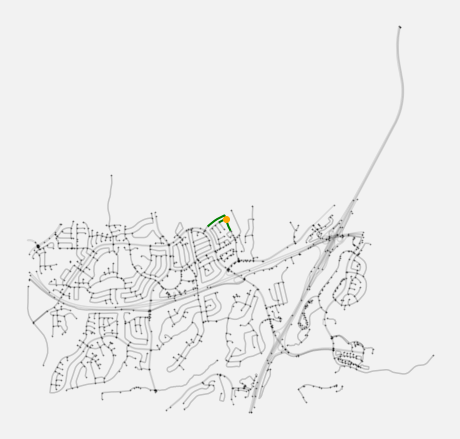

In [71]:
connected_edges = network.edges.loc[node.name, :, :]
connected_edges

# Plot network
fig, ax = network.plot_basic()

# Plot node
network.plot_node(ax, node)

# Plot connected edges
connected_edges.plot(ax = ax, linewidth = 2, color = "green")
display()

## Calculate energy to traverse edge

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/211948/simplified-guide-to-lorry-types-and-weights.pdf

https://en.wikipedia.org/wiki/Rolling_resistance

In [73]:
# Get all edge ids and pick a random one
edge_ids = network.get_edge_ids()
test_id = edge_ids[randrange(0, len(edge_ids))]

edge = network.get_edge(test_id)

display(edge)


def getEnergy(edge):
    node_0 = network.get_node( edge.name[0] )
    node_1 =network.get_node( edge.name[1] )
    
    # print(node_0)
    
    # ====== TRUCK PARAMS
    
    # MASS
    m_tonnes = 25 # INPUT - 3 axles rigid
    m_kg = m_tonnes * 1000
    
    # BREAKING
    regen_breaking_efficiency = 0.4 # INPUT Amount of energy regained
    
    # ROLLING RESISTANCE
    rolling_resistance_coefficient = 0.01 # INPUT "Ordinary car tires on concrete"
    normal_force_N = m_kg * 9.81
    rolling_resistance_force = rolling_resistance_coefficient * normal_force_N
    
    stopping_chance = 0.25 # Chance of requiring a stop at an intersection
    
    
    # Calculate speed of road in m/s
    m = re.match("[0-9]+", str(edge["maxspeed"]))
    if(m == None):
        speed_lim_mph = 20
    else:
        speed_lim_mph = int(m.group(0))
        
    v = speed_lim_mph * 0.44704 # mph to m/s
    
    # Calculate distance of road in meters
    d = float(edge["length"])
    
    
    # Kinetic energy
    KE = 0.5 * m_kg * v**2
    KE = KE - regen_breaking_efficiency * KE # Remove energy regained from regen
    KE = KE * stopping_chance # Chance of requiring a full stop
    
    # Potential energy
    delta_h = node_0['elevation'] - node_1['elevation']
    PE = m_kg * delta_h
    
    # Rolling resistance
    RR_E = d * rolling_resistance_force
    
    
    # print("Energy required to traverse edge:")
    # print("Kinetic Energy", round(KE / 1000), "kJ")
    # print("Rolling resistance", round(RR_E / 1000), "kJ")
    
    return((KE + RR_E) / 1000)
    
getEnergy(edge)

osmid                                               216891723
name                                                      NaN
highway                                                 track
oneway                                                  False
length                                                  90.08
geometry    LINESTRING (-117.1058207 32.9513248, -117.1055...
maxspeed                                                  NaN
lanes                                                     NaN
access                                                    NaN
bridge                                                    NaN
ref                                                       NaN
service                                                   NaN
landuse                                                   NaN
width                                                     NaN
Name: (49421616, 2262130081, 0), dtype: object

370.80477119999995

In [74]:
def getPathEnergy(edges):
    total_energy = 0.0
    
    for edge_id in edges.index:
        edge_details = network.get_edge(edge_id)
            
        total_energy += getEnergy(edge_details)
        
    return total_energy

def getPathLength(edges):
    total_length = 0.0
    
    for edge_id in edges.index:
        edge_details = network.get_edge(edge_id)
            
        total_length += edge_details['length']
        
    return total_length

## Dijkstra’s algo

In [97]:
node_ids = copy.copy(network.get_node_ids())

source_node_id = node_ids[52]
#source_node_id = 27089788
goal_node_id = node_ids[400]
#goal_node_id = 3380860046
print(source_node_id)

distances = pd.DataFrame({"dist": pd.Series(dtype='float'), "prev": pd.Series(dtype='int')}, index=node_ids)
#distances.set_index(node_ids)
Q = node_ids

distances['dist'][source_node_id] = 0.0
#distances['prev'][source_node_id] = source_node_id

print(distances['prev'][source_node_id].astype("int64"))

edge_list = []
filenames = []

49612145
-9223372036854775808


In [100]:
def iterate_dijkstras():
    global Q
    
    # For the nodes remaining in Q, find the one with the shortest distance
    u = distances[distances.index.isin(Q)]['dist'].idxmin()

    # Drop the node from the reminaing list to search
    Q = Q.drop(u)

    # Add new things
    edge_list.append((distances['prev'][u].astype("int64"), u, 0))
    
    try:
        # Find connected edges
        connected_edges = network.edges.loc[u, :, :].index

        # Loop through edges
        for edge_id in connected_edges:
            # Pick second node
            v = edge_id[1]
            
            edge_details = network.get_edge(edge_id)
            length = getEnergy(edge_details)
            
            #length = network.edges['length'][edge_id]
            # print(length)

            # Calculate distance from starting node to current node
            alt = distances['dist'][u] + length

            # print(u, v)

            # If the distance is lower than the current distance,
            # set it as the current shortest distance for the node and
            # set previous node
            if alt < distances['dist'][v] or np.isnan(distances['dist'][v]):
                distances['dist'][v] = alt
                distances['prev'][v] = u
    except KeyError as e:
        # print(e)
        print("no key found")
        
#     if(len(Q) % 50 == 0):
#         print("50th iter")
        
#         fig, ax = network.plot_basic((10, 10))
        
#         edges = network.edges[network.edges.index.isin(edge_list)]
#         edges.plot(ax = ax, color = "black")
        
#         network.plot_node_from_id(ax, source_node_id, "green")
#         network.plot_node_from_id(ax, goal_node_id, "red")
        
#         filename = f'frames/{len(Q)}.png'
#         filenames.append(filename)
#         plt.savefig(filename)
#         plt.close()
        
    # print(len(Q))

In [84]:
def dijkstras_reverse():
    node_ids = []
    edge_ids = []
    u = goal_node_id
    prev_u = 0
    
    if( (not np.isnan(distances['prev'][u])) or u != source_node_id):
        while not np.isnan(u):
            node_ids.insert(0, u)
            
            prev_u = u
            u = distances['prev'][u]
            edge_ids.append((u, prev_u, 0))

    # print(edge_ids[:-1])
    edges = network.edges[network.edges.index.isin(edge_ids[:-1])]
    print(len(edge_ids[:-1]))
    print(len(edges))
        
    return node_ids, edges

In [101]:
node_ids = copy.copy(network.get_node_ids())
distances = pd.DataFrame({"dist": pd.Series(dtype='float'), "prev": pd.Series(dtype='int')}, index=node_ids)
#distances.set_index(node_ids)
Q = node_ids

distances['dist'][source_node_id] = 0.0
#distances['prev'][source_node_id] = source_node_id

print(distances['prev'][source_node_id].astype("int64"))

edge_list = []

filenames = []

while goal_node_id in Q:
    iterate_dijkstras()
    
node_ids, edges = dijkstras_reverse()
print("done!")

-9223372036854775808
no key found
no key found
no key found
no key found
no key found
no key found
no key found
no key found
no key found
61
61
done!


94
37421 kJ
10.39 kWh
8.7 km
5.4 miles


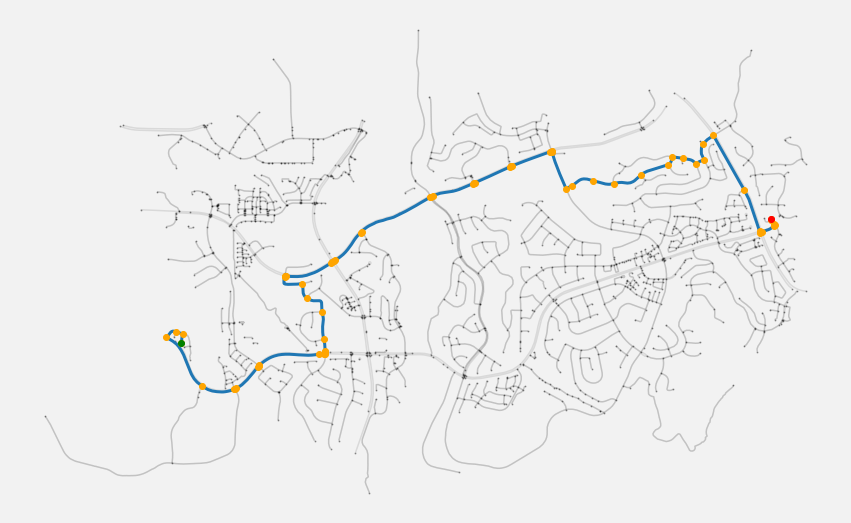

In [102]:
# Plot network
fig, ax = network.plot_basic((15, 15))



# Plot node
#network.plot_node_from_id(ax, u)
for node_id in node_ids:
    network.plot_node_from_id(ax, node_id)
    
network.plot_node_from_id(ax, source_node_id, "green")
network.plot_node_from_id(ax, goal_node_id, "red")

edges.plot(ax = ax, linewidth = 3)


#edges = network.edges[network.edges.index.isin(edge_list)]
#edges.plot(ax = ax, color = "black")

print(len(Q))

path_energy = getPathEnergy(edges)
print(round(path_energy), "kJ")
print(round(path_energy / 3600, 2), "kWh")

path_length = getPathLength(edges)
print(round(path_length / 1000, 2), "km")
print(round(path_length / 1000 * 0.6213712, 2), "miles")

In [514]:
print(filenames)

frames = []

for filename in filenames:
    image = imageio.imread(filename)
    frames.append(image)
    
# Plot network
fig, ax = network.plot_basic((10, 10))

# Plot node
#network.plot_node_from_id(ax, u)
for node_id in node_ids:
    network.plot_node_from_id(ax, node_id)
    
network.plot_node_from_id(ax, source_node_id, "green")
network.plot_node_from_id(ax, goal_node_id, "red")

edges.plot(ax = ax, linewidth = 3)

#edges = network.edges[network.edges.index.isin(edge_list)]
#edges.plot(ax = ax, color = "black")

print(len(Q))
# print(edge_list)

plt.savefig("frames/finish.png")
plt.close()

# frames.append(imageio.imread("frames/finish.png"))
# frames.append(imageio.imread("frames/finish.png"))
# frames.append(imageio.imread("frames/finish.png"))
# frames.append(imageio.imread("frames/finish.png"))
# frames.append(imageio.imread("frames/finish.png"))
# frames.append(imageio.imread("frames/finish.png"))

kargs = { 'duration': 0.05}
imageio.mimsave("testgif.gif", frames, 'GIF', **kargs)

[]
58


RuntimeError: Zero images were written.

In [1234]:
network.edges[network.edges.index.isin([(8333764709, 4210749313, 0)])]

,,,osmid,lanes,ref,name,highway,maxspeed,oneway,length,geometry,access,service
u,v,key,,,,,,,,,,,
8333764709,4210749313,0,616345392,2,A217,Wandsworth Bridge Road,primary,20 mph,False,75.372,"LINESTRING (-0.19277 51.47602, -0.19249 51.47536)",NaN,NaN


# Testing

In [915]:
network.edges.index

#edge_list

MultiIndex([(8333764709, 4210749313, 0),
            (8461004978,   27089772, 0),
            (8461004978, 8464405980, 0),
            (8461004978,   27089770, 0),
            (2204803282, 3965400001, 0),
            (2204803282, 3702436342, 0),
            (2204803282, 3702436349, 0),
            (1138944229, 1138944290, 0),
            (1138944238, 3450884703, 0),
            (1138944238, 3451067745, 0),
            ...
            (  14662752, 8464449407, 0),
            (  14662752,   14662754, 0),
            (  14662752,   14662751, 0),
            (7624016573, 7624016570, 0),
            (7624016574, 7624016570, 0),
            (7624016574, 7624016575, 0),
            (7624016574, 7624016562, 0),
            (7624016575,   27122371, 0),
            (7624016575,   14662766, 0),
            (7624016575, 7624016574, 0)],
           names=['u', 'v', 'key'], length=276)

In [13]:
network.generate_elevations()
network.nodes

{'y': 51.4760163, 'x': -0.1927744, 'elevation': 1.0}
{'y': 51.4730003, 'x': -0.1888155, 'elevation': 1.0}
{'y': 51.4721998, 'x': -0.192918, 'elevation': 1.0}
{'y': 51.4722958, 'x': -0.1915247, 'elevation': 1.0}
{'y': 51.4741423, 'x': -0.1959669, 'elevation': 1.0}
{'y': 51.4723525, 'x': -0.192173, 'elevation': 1.0}
{'y': 51.4736654, 'x': -0.1892866, 'elevation': 1.0}
{'y': 51.471729, 'x': -0.1925895, 'elevation': 1.0}
{'y': 51.4728224, 'x': -0.1916634, 'elevation': 1.0}
{'y': 51.4745468, 'x': -0.189205, 'elevation': 1.0}
{'y': 51.4746264, 'x': -0.189362, 'elevation': 1.0}
{'y': 51.4745892, 'x': -0.1894249, 'elevation': 1.0}
{'y': 51.4746674, 'x': -0.1892954, 'elevation': 1.0}
{'y': 51.4736364, 'x': -0.1918976, 'elevation': 1.0}
{'y': 51.4739115, 'x': -0.1902013, 'elevation': 1.0}
{'y': 51.4722775, 'x': -0.1916834, 'elevation': 1.0}
{'y': 51.4746221, 'x': -0.1890884, 'elevation': 1.0}
{'y': 51.4751701, 'x': -0.1891219, 'elevation': 1.0}
{'y': 51.4745422, 'x': -0.1900843, 'elevation': 1.0

,y,x,highway,geometry
osmid,,,,
8333764709,51.476016,-0.192774,NaN,POINT (-0.19277 51.47602)
8461004978,51.473000,-0.188815,NaN,POINT (-0.18882 51.47300)
1138944229,51.472200,-0.192918,NaN,POINT (-0.19292 51.47220)
1138944238,51.472296,-0.191525,NaN,POINT (-0.19152 51.47230)
25317627,51.474142,-0.195967,NaN,POINT (-0.19597 51.47414)
...,...,...,...,...
4210749313,51.475361,-0.192494,NaN,POINT (-0.19249 51.47536)
14662752,51.472881,-0.190867,NaN,POINT (-0.19087 51.47288)
7624016573,51.474150,-0.188732,NaN,POINT (-0.18873 51.47415)


https://api.open-elevation.com/api/v1/lookup?